In [1]:
import glob
import csv
import os
from tsne import bh_sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
from numpy.random import RandomState
np.random.seed(1)

In [2]:
asmdir = "Datasets/ByFamilyAsmOpcode"

In [3]:
cur_dir = os.getcwd()
os.chdir(asmdir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_asms = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.opcode'))  # assuming the asms are stored as 'opcode'
    no_asms.append(len1)
    os.chdir('..')
num_samples = np.sum(no_asms)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_asms:
    print ("Label:%2d\tFamily: %15s\tNumber of opcode: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
flist = [] # List of asm paths
print("Processing opcode ...")
for i in range(len(list_fams)):
    for asm_file in glob.glob(list_fams[i]+'/*.opcode'):
        #print("[%d] Processing asm: %s" % (cnt, asm_file))
        flist.append(os.path.join(os.getcwd(),asm_file))
        cnt += 1
print("Opcode processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of opcode: 362
Label: 1	Family:           alman	Number of opcode: 325
Label: 2	Family:          autoit	Number of opcode: 261
Label: 3	Family:            daws	Number of opcode: 466
Label: 4	Family:            delf	Number of opcode: 359
Label: 5	Family:         gamarue	Number of opcode: 259
Label: 6	Family:          ibryte	Number of opcode: 347
Label: 7	Family:          loring	Number of opcode: 285
Label: 8	Family:          mydoom	Number of opcode: 578
Label: 9	Family:          qukart	Number of opcode: 253
Label:10	Family:          ramnit	Number of opcode: 506
Label:11	Family:          sality	Number of opcode: 1401
Label:12	Family:          simbot	Number of opcode: 1148
Label:13	Family:       softpulse	Number of opcode: 912
Label:14	Family:          viking	Number of opcode: 183
Label:15	Family:         virlock	Number of opcode: 373
Label:16	Family:          vobfus	Number of opcode: 405
Label:17	Family:          wapomi	Number of opcode: 345
Label:18

In [4]:
num_samples = len(flist)
print("Number of samples: %i" %(num_samples))

Number of samples: 10132


In [5]:
flist

['/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/da3150b355718bbea9784f7236d4d0faefde69f307b86886bc770dec63e30851.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/96fce9e2944b2305b5b813c6f6ccc8011577f7cd1c0980c2b042815a03eb9d86.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/391413c9d6b4ac860335af719901071b536e3fc2d001504c7629d8de6369edaf.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/dedc9f72c4949c70071f1ac23edfe403cfd2b17cfca0f2fb33fdfc5246f46fd0.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/ff1f366f9e49cf0ec6280b89abe0070dbfa1917d2fdcc84d08180b859e91ad88.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/baa7b74b6d4d031b4f294fbb41a587d1dd5e4795cdf6dd9a5e357a2db4c0aba2.opcode',
 '/home/edmar/GIT/Malwares/VirusSign/20Classes/ByFamilyAsmOpcode/allaple/ae14a476cdfe6ed229d417110c01c05a2bf09f9d37d83

In [6]:
x86instructions = ['aaa','aad','aam','aas','adc','adcx','add','addpd','addps','addsd','addss','addsubpd','addsubps','adox','aesdec','aesdeclast','aesenc','aesenclast','aesimc','aeskeygenassist','and','andn','andnpd','andnps','andpd','andps','arpl','bextr','blendpd','blendps','blendvpd','blendvps','blsi','blsmsk','blsr','bound','bsf','bsr','bswap','bt','btc','btr','bts','bzhi','call','cbw','cdq','cdqe','clac','clc','cld','clflush','cli','clts','cmc','cmovcc','cmp','cmppd','cmpps','cmps','cmpsb','cmpsd','cmpsq','cmpss','cmpsw','cmpxchg','cmpxchg16b','cmpxchg8b','comisd','comiss','cpuid','cqo','crc32','cvtdq2pd','cvtdq2ps','cvtpd2dq','cvtpd2pi','cvtpd2ps','cvtpi2pd','cvtpi2ps','cvtps2dq','cvtps2pd','cvtps2pi','cvtsd2si','cvtsd2ss','cvtsi2sd','cvtsi2ss','cvtss2sd','cvtss2si','cvttpd2dq','cvttpd2pi','cvttps2dq','cvttps2pi','cvttsd2si','cvttss2si','cwd','cwde','daa','das','dec','div','divpd','divps','divsd','divss','dppd','dpps','emms','enter','extractps','f2xm1','fabs','fadd','faddp','fbld','fbstp','fchs','fclex','fcmovcc','fcom','fcomi','fcomip','fcomp','fcompp','fcos','fdecstp','fdiv','fdivp','fdivr','fdivrp','ffree','fiadd','ficom','ficomp','fidiv','fidivr','fild','fimul','fincstp','finit','fist','fistp','fisttp','fisub','fisubr','fld','fld1','fldcw','fldenv','fldl2e','fldl2t','fldlg2','fldln2','fldpi','fldz','fmul','fmulp','fnclex','fninit','fnop','fnsave','fnstcw','fnstenv','fnstsw','fpatan','fprem','fprem1','fptan','frndint','frstor','fsave','fscale','fsin','fsincos','fsqrt','fst','fstcw','fstenv','fstp','fstsw','fsub','fsubp','fsubr','fsubrp','ftst','fucom','fucomi','fucomip','fucomp','fucompp','fwait','fxam','fxch','fxrstor','fxsave','fxtract','fyl2x','fyl2xp1','haddpd','haddps','hlt','hsubpd','hsubps','idiv','imul','in','inc','ins','insb','insd','insertps','insw','int 3','int n','into','invd','invlpg','invpcid','iret','iretd','jmp','jcc','lahf','lar','lddqu','ldmxcsr','lds','lea','leave','les','lfence','lfs','lgdt','lgs','lidt','lldt','lmsw','lock','lods','lodsb','lodsd','lodsq','lodsw','loop','loopcc','lsl','lss','ltr','lzcnt','maskmovdqu','maskmovq','maxpd','maxps','maxsd','maxss','mfence','minpd','minps','minsd','minss','monitor','mov','movapd','movaps','movbe','movd','movddup','movdq2q','movdqa','movdqu','movhlps','movhpd','movhps','movlhps','movlpd','movlps','movmskpd','movmskps','movntdq','movntdqa','movnti','movntpd','movntps','movntq','movq','movq2dq','movs','movsb','movsd','movshdup','movsldup','movsq','movss','movsw','movsx','movsxd','movupd','movups','movzx','mpsadbw','mul','mulpd','mulps','mulsd','mulss','mulx','mwait','neg','nop','not','or','orpd','orps','out','outs','outsb','outsd','outsw','pabsb','pabsd','pabsw','packssdw','packsswb','packusdw','packuswb','paddb','paddd','paddq','paddsb','paddsw','paddusb','paddusw','paddw','palignr','pand','pandn','pause','pavgb','pavgw','pblendvb','pblendw','pclmulqdq','pcmpeqb','pcmpeqd','pcmpeqq','pcmpeqw','pcmpestri','pcmpestrm','pcmpgtb','pcmpgtd','pcmpgtq','pcmpgtw','pcmpistri','pcmpistrm','pdep','pext','pextrb','pextrd','pextrq','pextrw','phaddd','phaddsw','phaddw','phminposuw','phsubd','phsubsw','phsubw','pinsrb','pinsrd','pinsrq','pinsrw','pmaddubsw','pmaddwd','pmaxsb','pmaxsd','pmaxsw','pmaxub','pmaxud','pmaxuw','pminsb','pminsd','pminsw','pminub','pminud','pminuw','pmovmskb','pmovsx','pmovzx','pmuldq','pmulhrsw','pmulhuw','pmulhw','pmulld','pmullw','pmuludq','pop','popa','popad','popcnt','popf','popfd','popfq','por','prefetchw','prefetchwt1','prefetchh','psadbw','pshufb','pshufd','pshufhw','pshuflw','pshufw','psignb','psignd','psignw','pslld','pslldq','psllq','psllw','psrad','psraw','psrld','psrldq','psrlq','psrlw','psubb','psubd','psubq','psubsb','psubsw','psubusb','psubusw','psubw','ptest','punpckhbw','punpckhdq','punpckhqdq','punpckhwd','punpcklbw','punpckldq','punpcklqdq','punpcklwd','push','pusha','pushad','pushf','pushfd','pxor','rcl','rcpps','rcpss','rcr','rdfsbase','rdgsbase','rdmsr','rdpmc','rdrand','rdseed','rdtsc','rdtscp','rep','repe','repne','repnz','repz','ret','rol','ror','rorx','roundpd','roundps','roundsd','roundss','rsm','rsqrtps','rsqrtss','sahf','sal','sar','sarx','sbb','scas','scasb','scasd','scasw','setcc','sfence','sgdt','shl','shld','shlx','shr','shrd','shrx','shufpd','shufps','sidt','sldt','smsw','sqrtpd','sqrtps','sqrtsd','sqrtss','stac','stc','std','sti','stmxcsr','stos','stosb','stosd','stosq','stosw','str','sub','subpd','subps','subsd','subss','swapgs','syscall','sysenter','sysexit','sysret','test','tzcnt','ucomisd','ucomiss','ud2','unpckhpd','unpckhps','unpcklpd','unpcklps','vbroadcast','vcvtph2ps','vcvtps2ph','verr','verw','vextractf128','vextracti128','vfmadd132pd','vfmadd132ps','vfmadd132sd','vfmadd132ss','vfmadd213pd','vfmadd213ps','vfmadd213sd','vfmadd213ss','vfmadd231pd','vfmadd231ps','vfmadd231sd','vfmadd231ss','vfmaddsub132pd','vfmaddsub132ps','vfmaddsub213pd','vfmaddsub213ps','vfmaddsub231pd','vfmaddsub231ps','vfmsub132pd','vfmsub132ps','vfmsub132sd','vfmsub132ss','vfmsub213pd','vfmsub213ps','vfmsub213sd','vfmsub213ss','vfmsub231pd','vfmsub231ps','vfmsub231sd','vfmsub231ss','vfmsubadd132pd','vfmsubadd132ps','vfmsubadd213pd','vfmsubadd213ps','vfmsubadd231pd','vfmsubadd231ps','vfnmadd132pd','vfnmadd132ps','vfnmadd132sd','vfnmadd132ss','vfnmadd213pd','vfnmadd213ps','vfnmadd213sd','vfnmadd213ss','vfnmadd231pd','vfnmadd231ps','vfnmadd231sd','vfnmadd231ss','vfnmsub132pd','vfnmsub132ps','vfnmsub132sd','vfnmsub132ss','vfnmsub213pd','vfnmsub213ps','vfnmsub213sd','vfnmsub213ss','vfnmsub231pd','vfnmsub231ps','vfnmsub231sd','vfnmsub231ss','vgatherdpd','vgatherdps','vgatherqpd','vgatherqps','vinsertf128','vinserti128','vmaskmov','vpblendd','vpbroadcast','vperm2f128','vperm2i128','vpermd','vpermilpd','vpermilps','vpermpd','vpermps','vpermq','vpgatherdd','vpgatherdq','vpgatherqd','vpgatherqq','vpmaskmov','vpsllvd','vpsllvq','vpsravd','vpsrlvd','vpsrlvq','vtestpd','vtestps','vzeroall','vzeroupper','wait','wbinvd','wrfsbase','wrgsbase','wrmsr','xabort','xacquire','xadd','xbegin','xchg','xend','xgetbv','xlat','xlatb','xor','xorpd','xorps','xrelease','xrstor','xrstors','xsave','xsavec','xsaveopt','xsaves','xsetbv','xtest']

In [7]:
vectorizer = CountVectorizer(input='filename', ngram_range=(2, 2), stop_words=None, decode_error='ignore', min_df=1)

In [8]:
filename = 'virussign-opcode2gram.npy'
if os.path.exists(filename):
    print("Loading Opcode2gram extracted features from %s ..." %(filename))
    X = np.load(filename)
else:
    print("Extracting Opcode2gram features ...")
    X = vectorizer.fit_transform(flist)
    X = X.todense()    
    print("Saving Opcode2gram extracted features into %s ..." %(filename))
    np.save(filename, X)

Extracting Opcode2gram features ...
Saving Opcode2gram extracted features into virussign-opcode2gram.npy ...


In [9]:
X

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
if (np.where(np.isnan(X)))[0].shape[0]: 
    print("X contains nan")
else:
    print("X does not contain nan")

X does not contain nan


In [11]:
X.shape

(10132, 18109)

In [12]:
y

array([  0.,   0.,   0., ...,  19.,  19.,  19.])

In [13]:
y.shape

(10132,)

In [14]:
no_asms

[362,
 325,
 261,
 466,
 359,
 259,
 347,
 285,
 578,
 253,
 506,
 1401,
 1148,
 912,
 183,
 373,
 405,
 345,
 859,
 505]

In [15]:
list_fams

['allaple',
 'alman',
 'autoit',
 'daws',
 'delf',
 'gamarue',
 'ibryte',
 'loring',
 'mydoom',
 'qukart',
 'ramnit',
 'sality',
 'simbot',
 'softpulse',
 'viking',
 'virlock',
 'vobfus',
 'wapomi',
 'zbot',
 'zegost']

In [16]:
print("Running t-SNE ...")
vis_data = bh_sne(np.float64(X), d=2, perplexity=30., theta=0.5, random_state=RandomState(1))
#vis_data = TSNE(n_components=2,random_state=1).fit_transform(X)

Running t-SNE ...


Plotting t-SNE ...


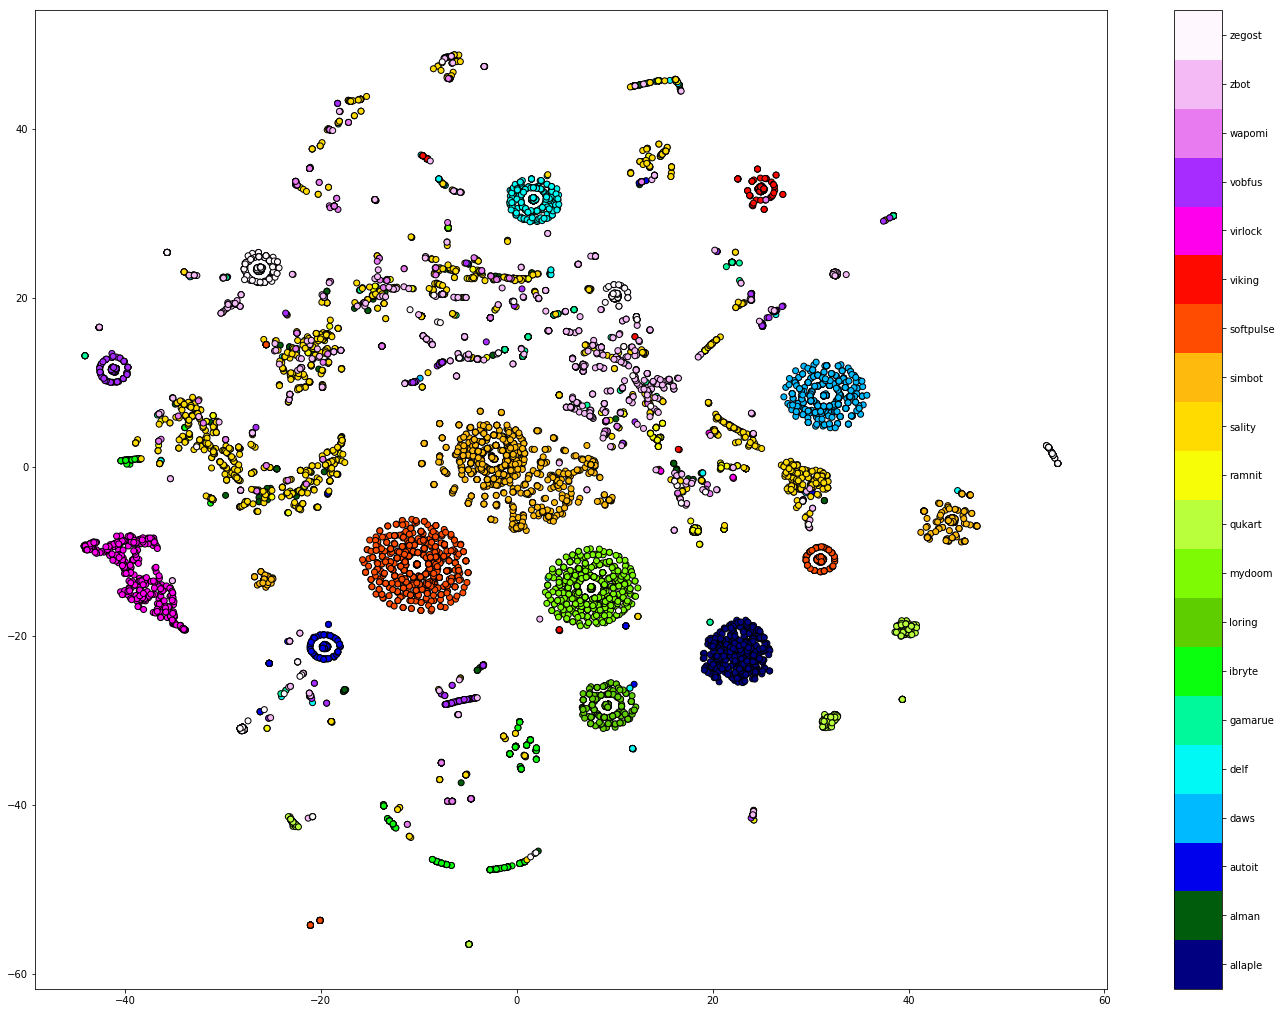

In [17]:
print("Plotting t-SNE ...")
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=y, cmap=plt.cm.get_cmap("gist_ncar", len(list_fams)),edgecolors="black")
plt.clim(-0.5, len(list_fams)-0.5)
cbar = plt.colorbar(ticks=range(len(list_fams)))
cbar.ax.set_yticklabels(list_fams)                     
plt.show()

In [18]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [19]:
# Training top_model and saving min training loss weights
n_neighbors = 1
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    top_model = KNeighborsClassifier(n_neighbors, weights='distance',n_jobs=-1)
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.9247
[1] Test acurracy: 0.9344
[2] Test acurracy: 0.9166
[3] Test acurracy: 0.9321
[4] Test acurracy: 0.9360
[5] Test acurracy: 0.9209
[6] Test acurracy: 0.9237
[7] Test acurracy: 0.9365
[8] Test acurracy: 0.9324
[9] Test acurracy: 0.9322


In [20]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9289


Plotting the confusion matrix


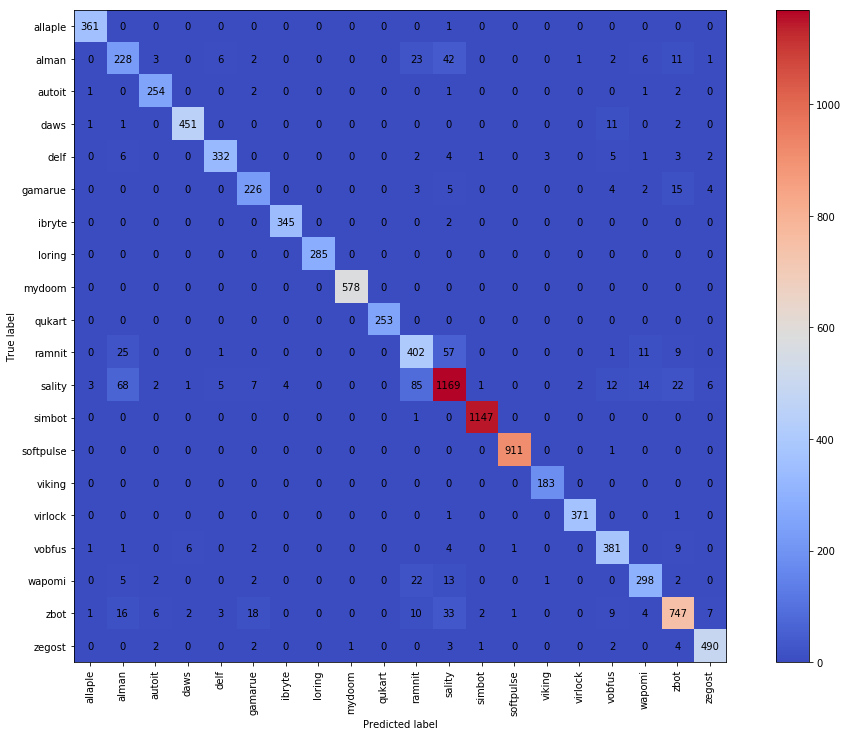

In [21]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


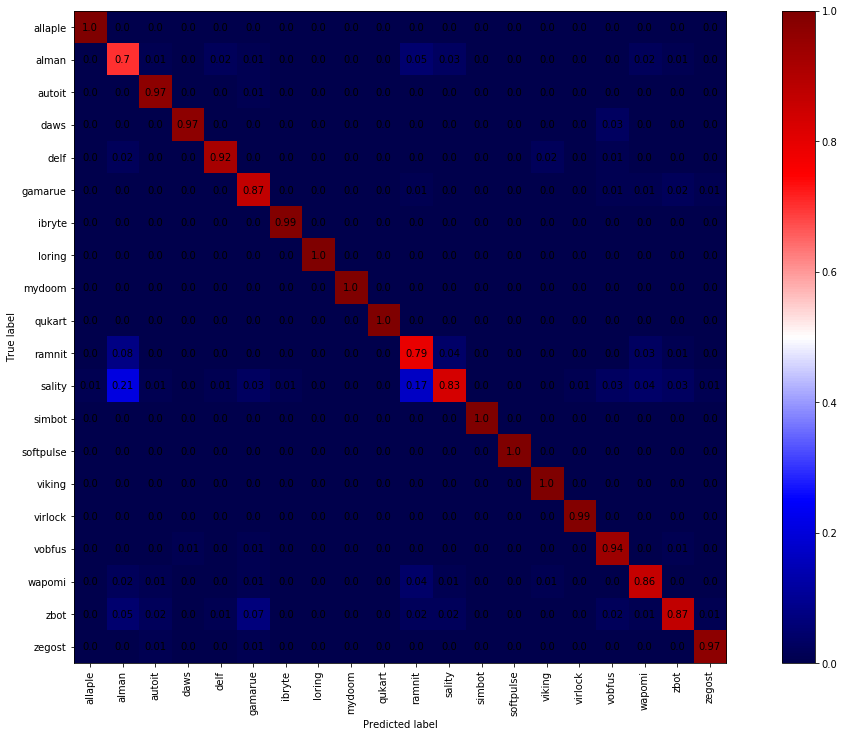

In [22]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


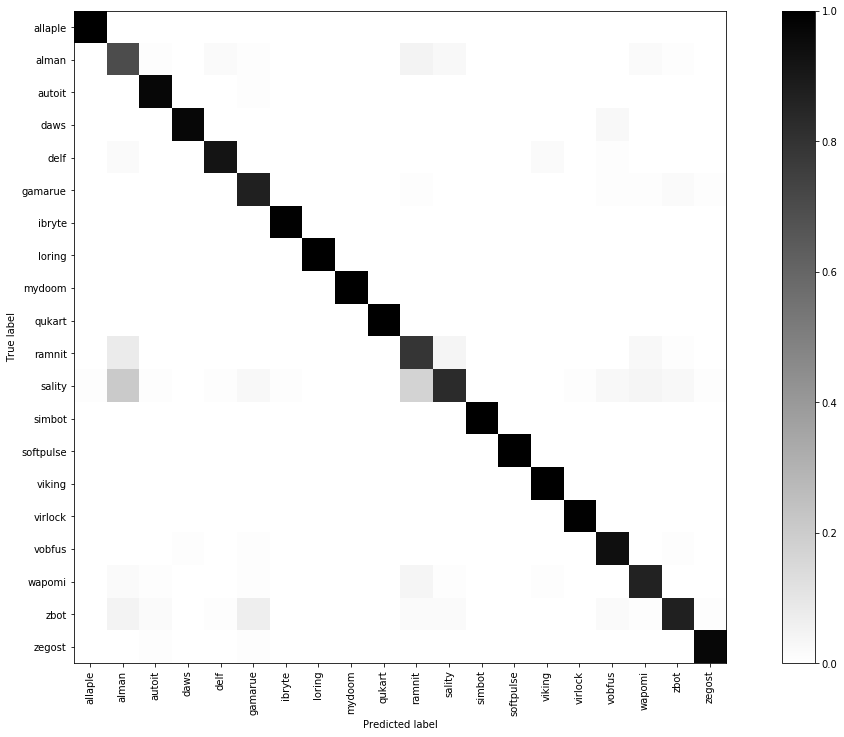

In [23]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
#for row in range(len(list_fams)):
#    for col in range(len(list_fams)):
#        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


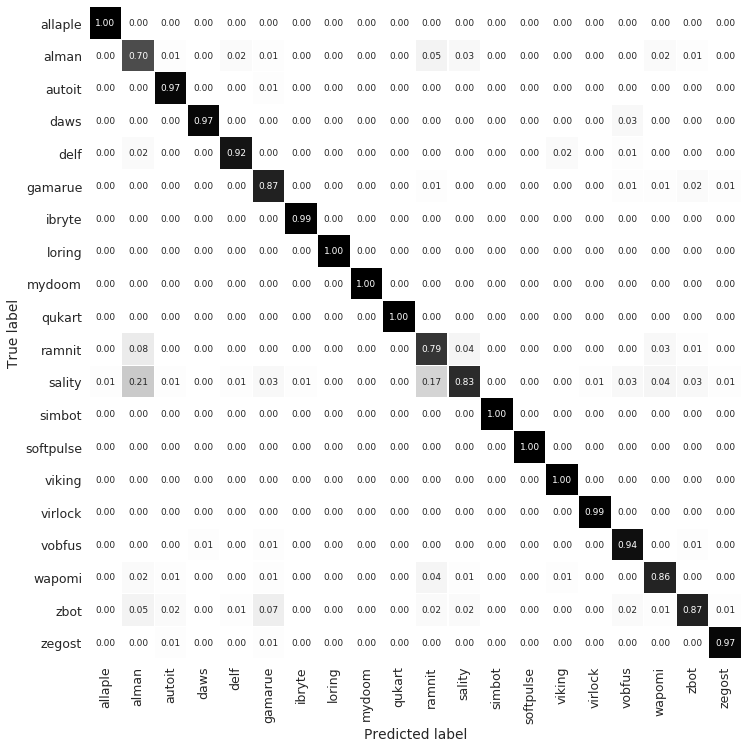

In [24]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()